In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,7.0)
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [2]:
data_x = pd.read_csv("x_train.csv")
data_y = pd.read_csv("y_train.csv")

In [3]:
data_x.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.0,90.4,5.9,3.6,0.1,79,Отсутствует,Plasticizer1,Polymer1,138,75
1,1,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer2,Polymer2,138,75
2,2,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer3,Polymer2,138,75


In [4]:
data_y.head(3)

,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,33.0,71.0,21.0,74.4,73.0
1,1,32.0,71.0,16.0,72.8,75.0
2,2,35.0,76.0,27.0,74.0,78.0


In [5]:
def get_train_dataset_x(data_x):
  encod_adg = LabelBinarizer()
  encod_plas = LabelBinarizer()
  encod_poly = LabelBinarizer()

  list_adg = encod_adg.fit_transform(data_x["Адгезионная добавка"])
  list_plas = encod_plas.fit_transform(data_x["Пластификатор"])
  list_poly = encod_poly.fit_transform(data_x["Полимер"])

  classificator = {"Адгезионная добавка": list_adg, "Пластификатор": list_plas, "Полимер": list_poly}
  deff = filter(lambda i: True if i not in classificator.keys() else False, data_x.columns)
  data_lab_x = data_x.copy()[deff]

  dfs = [data_lab_x]
  for k,v in classificator.items():
    df = pd.DataFrame(v, columns=[k+str(i) for i in range(v.shape[1])])
    dfs.append(df)
  data_class_x = pd.concat(dfs, axis=1)
  data_class_x

  data_X = data_class_x.copy()
  norm = MinMaxScaler()
  res = norm.fit_transform(data_X)
  for i, el in enumerate(data_class_x.columns):
    data_X[el] = res[:, i]
  X_train = data_X
  X_train["id"] = range(X_train.shape[0])

  return X_train, encod_adg, encod_plas, encod_poly, norm

In [6]:
X_train, *bins = get_train_dataset_x(data_x)

In [7]:
def get_test_dataset_x(data_x, bins):
  list_adg = bins[0].transform(data_x["Адгезионная добавка"])
  list_plas = bins[1].transform(data_x["Пластификатор"])
  list_poly = bins[2].transform(data_x["Полимер"])

  classificator = {"Адгезионная добавка": list_adg, "Пластификатор": list_plas, "Полимер": list_poly}
  deff = filter(lambda i: True if i not in classificator.keys() else False, data_x.columns)
  data_lab_x = data_x.copy()[deff]

  dfs = [data_lab_x]
  for k,v in classificator.items():
    df = pd.DataFrame(v, columns=[k+str(i) for i in range(v.shape[1])])
    dfs.append(df)
  data_class_x = pd.concat(dfs, axis=1)

  data_X = data_class_x.copy()
  res = bins[-1].transform(data_X)
  for i, el in enumerate(data_class_x.columns):
    data_X[el] = res[:, i]
  X_test = data_X[data_X.columns[1:]]
  return X_test

In [8]:
test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
X_test

,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,Адгезионная добавка0,Адгезионная добавка1,...,Пластификатор19,Пластификатор20,Пластификатор21,Пластификатор22,Пластификатор23,Пластификатор24,Полимер0,Полимер1,Полимер2,Полимер3
0,0.857143,0.757576,0.252024,0.000000,0.320988,0.181818,0.245509,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.857143,0.401382,0.620179,0.263158,0.506173,0.181818,0.616766,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.857143,0.608719,0.363512,0.473684,0.654321,0.181818,0.359281,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.539607,0.440357,0.631579,0.765432,0.181818,0.437126,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.566188,0.392202,0.789474,0.876543,0.181818,0.389222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.857143,0.635300,0.272440,1.000000,1.024691,0.181818,0.269461,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.857143,0.667198,0.255119,0.842105,0.913580,0.181818,0.251497,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.857143,0.736310,0.214524,0.526316,0.691358,0.181818,0.209581,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.000000,0.863902,0.138571,0.105263,0.395062,0.181818,0.131737,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.000000,0.810739,0.167440,0.368421,0.580247,0.181818,0.161677,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
def get_train_dataset_y(data_y):
  data_Y = data_y.copy()
  index1 = data_Y[["id", "Эластичность при 0 °С, [%]"]].dropna()[data_Y.columns[0]].to_numpy()
  index4 = data_Y[data_Y.columns[:-1]].dropna()[data_Y.columns[0]].to_numpy()
  data_Y = data_Y[data_Y.columns[1:]]
  norm = MinMaxScaler()
  res = norm.fit_transform(data_Y)
  for i, el in enumerate(data_Y.columns):
    data_Y[el] = res[:, i]
  Y_train = data_Y
  Y_train4 = Y_train[Y_train.columns[:-1]].dropna()
  Y_train1 = Y_train[Y_train.columns[-1]].dropna()
  return Y_train1, Y_train4, norm, index1, index4

In [10]:
Y_train1, Y_train4, norm, *index = get_train_dataset_y(data_y)

Y_train4

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]"
0,0.31250,0.184466,0.178571,0.733333
1,0.28125,0.184466,0.089286,0.657143
2,0.37500,0.233010,0.285714,0.714286
3,0.21875,0.126214,0.035714,0.761905
4,0.28125,0.135922,0.053571,0.761905
...,...,...,...,...
103,0.34375,0.184466,0.696429,0.714286
104,0.28125,0.184466,0.244643,0.714286
105,0.25000,0.194175,0.232143,0.666667
106,0.28125,0.126214,0.089286,0.761905


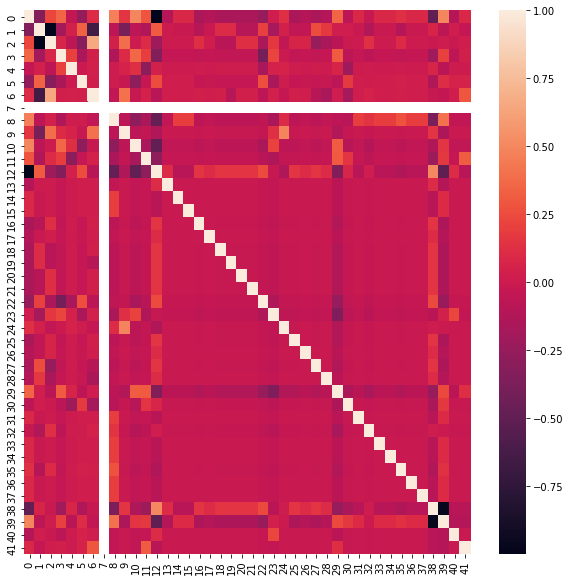

In [187]:
import seaborn as sns
X_train, *bins = get_train_dataset_x(data_x)
X_train4 = X_train[X_train["id"].isin(index[1])][X_train.columns[1:]]
X_train1 = X_train[X_train["id"].isin(index[0])][X_train.columns[1:]]
plt.figure(figsize = (10,10))
sns.heatmap(data=X_train4.corr().to_numpy(), annot=False)

#Создание модели обучения

In [209]:
import tensorflow as tf
models = []
for i in range(5):
  model = Sequential()
  model.add(Dense(22, activation="relu", input_shape = (X_train4.shape[1],)))
  model.add(Dense(1, activation="elu"))
  model.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
  models.append(model)

In [210]:
historys = []
for i, el in enumerate(models):
  if i!=4:
    history = el.fit(X_train4, Y_train4, epochs=250, validation_split = 0.1, batch_size=120)
  else:
    history = el.fit(X_train1, Y_train1, epochs=250, validation_split = 0.1, batch_size=120)
  historys.append(history)

Epoch 1/250
1/1 [==============================] - 0s 417ms/step - loss: 0.3184 - root_mean_squared_error: 0.5643 - val_loss: 0.1714 - val_root_mean_squared_error: 0.4140
Epoch 2/250
1/1 [==============================] - 0s 23ms/step - loss: 0.3020 - root_mean_squared_error: 0.5496 - val_loss: 0.1596 - val_root_mean_squared_error: 0.3994
Epoch 3/250
1/1 [==============================] - 0s 22ms/step - loss: 0.2862 - root_mean_squared_error: 0.5350 - val_loss: 0.1486 - val_root_mean_squared_error: 0.3855
Epoch 4/250
1/1 [==============================] - 0s 35ms/step - loss: 0.2711 - root_mean_squared_error: 0.5207 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 5/250
1/1 [==============================] - 0s 26ms/step - loss: 0.2567 - root_mean_squared_error: 0.5067 - val_loss: 0.1296 - val_root_mean_squared_error: 0.3600
Epoch 6/250
1/1 [==============================] - 0s 27ms/step - loss: 0.2430 - root_mean_squared_error: 0.4930 - val_loss: 0.1215 - val_root_mean_s

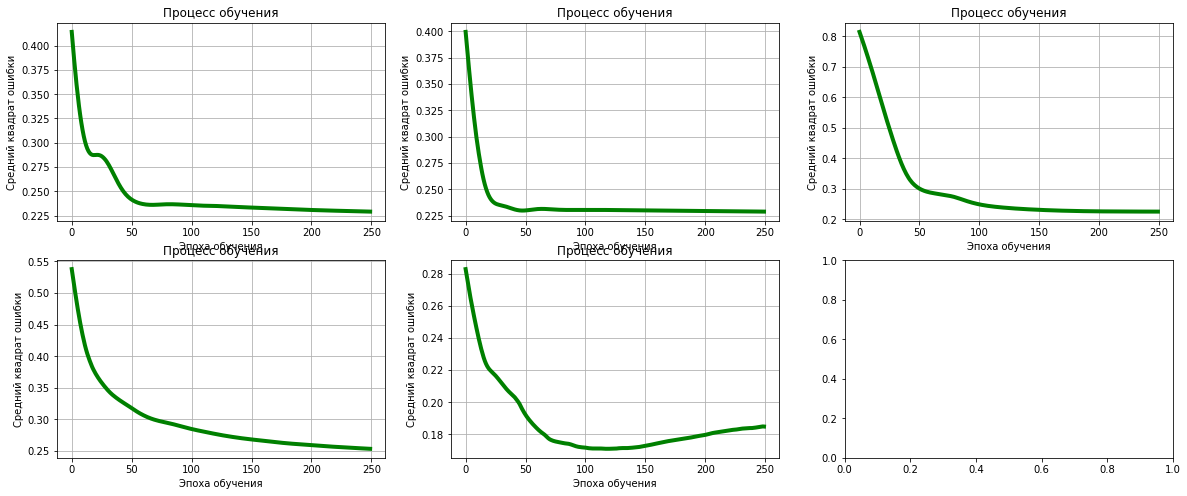

In [212]:
fig, plots = plt.subplots(
    nrows=2, ncols=3,
    figsize=(20, 8)
)
plots = plots.reshape(-1)
for i in range(len(plots)-1):
  plots[i].plot(historys[i].history['val_root_mean_squared_error'],color = 'g',linewidth = 4)
  plots[i].grid(True)
  plots[i].set_title('Процесс обучения')
  plots[i].set_xlabel('Эпоха обучения')
  plots[i].set_ylabel('Средний квадрат ошибки')

In [213]:
test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
model4_old = tf.keras.models.load_model("model4_1331.h5")
model1_old = tf.keras.models.load_model("model1_1331.h5")
Y_test4 = model4_old.predict(X_test)
Y_test1 = model1_old.predict(X_test)
num = Y_test4.shape[0]
result = np.ones((num, 5))
result[:,0:-1] = Y_test4
result[:,-1] =Y_test1.reshape(-1)
Fin = norm.inverse_transform(result).round(1)
Fin

array([[32.6, 68.8, 10. , 74.7, 75.8],
       [41.8, 68.1, 38.3, 74. , 80.8],
       [36.8, 75.1, 20.5, 77.3, 77.4],
       [32.2, 78.9, 29.6, 69.9, 73. ],
       [28.4, 74.7, 30.8, 74.3, 72.1],
       [30.7, 78.1, 28.2, 80.6, 78.4],
       [32.2, 86.4, 26.9, 77.9, 79.3],
       [26.2, 68.9, 25.2, 66.2, 77.8],
       [31.6, 77.6, 27.8, 62.6, 78.1],
       [30.9, 65. , 28.2, 71.4, 76.7]])

In [200]:
test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
Y_test4 = model4.predict(X_test)
Y_test1 = model1.predict(X_test)
num = Y_test4.shape[0]
result = np.ones((num, 5))
result[:,0:-1] = Y_test4
result[:,-1] =Y_test1.reshape(-1)
Fin = norm.inverse_transform(result).round(1)
Fin

array([[ 24.6,  81.4,   8.9,  75.7,  77.3],
       [ 38.9, 107.4,  43. ,  71. ,  77.8],
       [ 31. ,  76. ,  19.7,  75.9,  79.3],
       [ 30.8,  75.5,  31.8,  71.5,  70.9],
       [ 30.1,  63.7,  32.6,  75.2,  75.9],
       [ 37.2,  71.9,  14.5,  73.1,  86.7],
       [ 30.7,  75.6,  21.3,  74.9,  74.9],
       [ 33.1,  53. ,  19. ,  64.9,  74.4],
       [ 32.5,  70.4,  31.2,  62.8,  78.3],
       [ 29.8,  64.9,  28.5,  72.3,  79. ]])

In [214]:
df = pd.DataFrame(Fin, columns=data_y.columns[1:])
sr = pd.Series(range(num), name="id")
Y_test = pd.concat([sr, df], axis = 1)
Y_test.to_csv("result.csv", index=False)
m = tf.keras.metrics.RootMeanSquaredError()
y_real = pd.read_csv("submission_example.csv")
for i in range(1,y_real.shape[1]):
  m = tf.keras.metrics.RootMeanSquaredError()
  m.update_state(Y_test.to_numpy()[:,i], y_real.to_numpy()[:, i])
  print(m.result().numpy())

print()
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(Y_test.to_numpy()[:,1:], y_real.to_numpy()[:, 1:])
print(m.result().numpy())

3.8140528
7.190132
6.13327
5.2963195
3.6575966

5.390566


In [95]:
model4.save("model4_.h5")
model1.save("model1_.h5")